# Implement MLGCN on ODIR dataset

* **Link to the paper:** https://arxiv.org/pdf/1912.11757.pdf 

Start with graph construction from the given patients' data. To have the similar input to the load function we build for BlogCatalog dataset, we will create two csv files, `edges.csv` and `group-edges.csv`.

The patients are conected if they have age difference less than 5-year-old, this information is than recorded in `edges.csv`, the first column is the patient node and second column is its connected node.

Information of nodes and their correponding labels is saved as `group-edges.csv`.

In [1]:
import pandas as pd 
import numpy as np 
import itertools

In [2]:
prepro_data = pd.read_csv("full_df.csv")
unique_IDs = np.unique(prepro_data["ID"])
new_ids = []
for ind in unique_IDs: 
    if (prepro_data[prepro_data['ID'] == ind].shape[0]) == 2:
        new_ids.append(ind)
prepro_data = prepro_data[prepro_data.ID.isin(new_ids)]
prepro_data = prepro_data.drop_duplicates(subset = ["ID"])

In [3]:
prepro_data["node_ID"] = [i for i in range(1,3035, 1)]

In [4]:
mapping_data = prepro_data[["ID", "node_ID"]]

**Edge.csv Construction**

In [12]:
list_edges = []
edges = []

In [13]:
female_data = prepro_data[prepro_data["Patient Sex"] == "Female"]
male_data = prepro_data[prepro_data["Patient Sex"] == "Male"]
female_patient_age = np.array(female_data["Patient Age"])
male_patient_age = np.array(male_data["Patient Age"])
female_IDs = np.array(female_data["ID"])
male_IDs = np.array(male_data["ID"])

for age in np.unique(female_patient_age):
    indices = np.argwhere((female_patient_age - age) < 5).reshape(-1)
    same_age_ids = female_IDs[indices]
    for subset in itertools.combinations(same_age_ids, 2):
        list_edges.append(subset)   
        edges.append(str(subset[0]) + "," + str(subset[1]) + "\n")

for age in np.unique(male_patient_age):
    indices = np.argwhere((male_patient_age - age) < 5).reshape(-1)
    same_age_ids = male_IDs[indices]
    for subset in itertools.combinations(same_age_ids, 2):
        list_edges.append(subset)   
        edges.append(str(subset[0]) + "," + str(subset[1]) + "\n")


In [14]:
edges_file = "ODIR/edges.csv"
df = pd.DataFrame(list())
df.to_csv(edges_file)
f = open(edges_file, "r+")
f.writelines(edges)
f.close()

**Group-edges.csv Construction**

In [15]:
label_data = prepro_data[["ID", "node_ID", "N", "D", "G", "C", "A", "H", "M", "O"]]

In [16]:
IDs = np.array(label_data["node_ID"])
labels = []
list_edges = []
edges = []
for ID in IDs:
    line = label_data[label_data["node_ID"] == ID]
    l = [int(line["N"]),int(line["D"]),int(line["G"]),int(line["C"]),int(line["A"]),int(line["H"]),int(line["M"]),int(line["O"])]
    labels.append(l)
    indices = np.argwhere(np.array(l) == 1).reshape(-1)
    for i in indices:
        list_edges.append([ID,i+1])
        edges.append(str(ID) + "," + str(i+1) + "\n")

In [17]:
node_label_file = "ODIR/group-edges.csv"
df = pd.DataFrame(list())
df.to_csv(node_label_file)
f = open(node_label_file, "r+")
f.writelines(edges)
f.close()

### Load Function and custom made functions

`normalize` : used in the normalization step for the adjacency matrix

`threshold` : used for defining the sigmoid output to 0 or 1

`accuracy_sample_class` : accuracy for samples having multilabels

`micor_F1` : built based on the equations provided in the paper

`load_data` : creating the input feature matrices, adjacency matrices and embeddings as input to the model

In [18]:
# number of labels
m = 8
# number of patients
n = 3034
# number of features
nfeatures = 4096 

In [19]:
import pandas as pd 
import numpy as np
import networkx as nx
import scipy.sparse as sp
from sklearn import preprocessing
import matplotlib.pyplot as plt
import csv
import torch
import itertools 

In [20]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [21]:
def threshold(output):
    output[output > 0.5] = 1
    output[output <= 0.5] = 0
    return output

In [22]:
def micro_F1(output, labels):
    TP = np.array([])
    FN = np.array([])
    FP = np.array([])
    N = labels.shape[0]
    L = labels.shape[1]
    for l in range(L):
        tp = 0
        fn = 0
        fp = 0
        ol = output[:,l]
        ll = labels[:,l]
        for i in range(N):
            if ll[i] == 1 and ol[i] == 1:
                tp +=1
            if ol[i] == 0 and ll[i] == 1:
                fn +=1
            if ol[i] == 1 and ll[i] == 0:
                fp +=1
        TP = np.append(TP, tp)
        FN = np.append(FN, fn)
        FP = np.append(FP, fp)
    return np.sum(2*TP)/np.sum(2*TP + FN + FP)

In [23]:
def load_data(data_name):
    edges_file = data_name + "/edges.csv"
    node_label_file = data_name + "/group-edges.csv"
    #label_occ_file = data_name + "/label_co-occurences.csv"
    nnlg_file = data_name + "/edges_node_node_label.csv"
    llng_file = data_name + "/edges_label_label_node.csv"
    label_raw, nodes = [], []
    with open(node_label_file) as file_to_read: 
        while True:
            lines = file_to_read.readline()
            if not lines:
                break 
            node, label = lines.split(",")
            label_raw.append(int(label))
            nodes.append(int(node))
    label_raw = np.array(label_raw)
    nodes = np.array(nodes)
    unique_nodes = np.unique(nodes)
    labels = np.zeros((unique_nodes.shape[0], m))
    for l in range(1, m+1, 1):
        indices = np.argwhere(label_raw == l).reshape(-1)
        n_l = nodes[indices]
        for n in n_l:
            labels[n-1][l-1] = 1
            
    main_graph = open(edges_file, "rb")
    G = nx.read_edgelist(main_graph, delimiter = ",", nodetype = int)
    A = nx.adjacency_matrix(G, nodelist = unique_nodes)
    A = sp.coo_matrix(A.todense())
    # Normalize the adjancency matrix with the added self loops
    A_tilde = normalize(A + 3*sp.eye(A.shape[0]))
    
    # node-node-label graph 
    label_nodes = label_raw + unique_nodes.shape[0] 
    n_n_l_nodes = np.concatenate((unique_nodes, np.unique(label_nodes)))
    df = pd.DataFrame(list())
    df.to_csv(nnlg_file)
    f = open(nnlg_file, "r+")
    file_to_read = open(edges_file, "r")
    f.writelines(file_to_read.readlines())
    a = np.dstack((nodes, label_nodes)).reshape(label_nodes.shape[0],2)
    e = ["\n"] + [",".join(item)+"\n" for item in a.astype(str)]
    f.writelines(e)
    f.close()
    
    nnl_graph = nx.read_edgelist(nnlg_file, delimiter = ",", nodetype = int)
    E = nx.adjacency_matrix(nnl_graph, nodelist = n_n_l_nodes)
    # Normalize the adjancency matrix with the added self loops
    E = normalize(E + 3*sp.eye(E.shape[0]))
    E_tilde = E[:len(unique_nodes)]
    
    # Label-label-node graph 
    edges = []
    list_edges = []
    for k in range(labels.shape[0]):
        indices = np.argwhere(labels[k] == 1).reshape(-1)
        if indices.shape[0]>1:
            for subset in itertools.combinations(indices, 2): 
                if (list(subset) not in list_edges) or ([subset[1], subset[0]] not in list_edges):
                    list_edges.append([subset[0], subset[1]+labels.shape[0]])# check if the common nodes should be before or after the label nodes
                    edges.append(str(subset[0]+1) + "," + str(subset[1] +1) + "\n")
    df = pd.DataFrame(list())
    df.to_csv(llng_file)
    label_file = open(llng_file, "r+")
    label_file.writelines(edges)
    label_file.close()
    
    unique_label_ID = np.arange(1,m+1)
    label_file = open(llng_file, "rb")
    label_graph = nx.read_edgelist(label_file, delimiter = ",", nodetype = int)
    C = nx.adjacency_matrix(label_graph, nodelist = unique_label_ID)
    label_file.close()
    # Normalize the co-occurence matrix with the added self loops
    C_tilde = normalize(C + 2*sp.eye(C.shape[0]))
    Y = np.random.rand(m,nfeatures) #instead of X[:m]
    Y_embedding = Y[:,:400]
    
    labels_ind = label_raw 
    nodes_ind = nodes + m
    a_1 = np.dstack((labels_ind,nodes)).reshape(labels_ind.shape[0],2)
    e_1 = [",".join(item)+"\n" for item in a_1.astype(str)]
    file = open(llng_file, "r+")
    file.writelines(e_1)
    file.close()
    
    
    f_1 = open(llng_file, "rb")
    l_l_n_nodes = np.concatenate((np.unique(nodes_ind),np.unique(labels_ind)))
    lln_graph = nx.read_edgelist(f_1, delimiter = ",", nodetype = int)
    F = nx.adjacency_matrix(lln_graph, nodelist = l_l_n_nodes)
    F = sp.coo_matrix(F.todense())
    f_1.close()
    
    # Normalize the adjancency matrix with the added self loops
    F = normalize(F + 2*sp.eye(F.shape[0]))
    F_tilde = F[:m]
    
    indices = np.arange(A.shape[0]).astype('int32') # should be shuffled
    np.random.shuffle(indices)
    
    # idx_train = indices[:A.shape[0] // 3]
    # idx_val = indices[A.shape[0] // 3: (2 * A.shape[0]) // 3]
    # idx_test = indices[(2 * A.shape[0]) // 3:]
    # idx_train = torch.LongTensor(idx_train)
    # idx_val = torch.LongTensor(idx_val)
    # idx_test = torch.LongTensor(idx_test)
    C_tilde = torch.FloatTensor(np.array(C_tilde.todense()))
    E_tilde = torch.FloatTensor(np.array(E_tilde.todense()))
    F_tilde = torch.FloatTensor(np.array(F_tilde.todense()))
    A_tilde = torch.FloatTensor(np.array(A_tilde.todense()))
    labels = torch.FloatTensor(labels)
    Y = torch.FloatTensor(Y)
    #X_embedding = torch.FloatTensor(X_embedding)
    Y_embedding = torch.FloatTensor(Y_embedding)
    
    return Y, Y_embedding, F_tilde, E_tilde, C_tilde, A_tilde, labels

In [24]:
Y, Y_embedding, F_tilde, E_tilde, C_tilde, A_tilde, labels = load_data("ODIR")

Import the X feature matrix from saved `X.csv` file, the file does not exist in the current folder due to large dataset,

create the file by the jupyter notebook provided in README file

In [30]:
# here is for importing the X feature matrix 
# which is extracted and saved from the fundus images from ODIR dataset
X = pd.read_csv("X.csv", sep=",", header = None)
X = torch.FloatTensor(X.to_numpy())

### Read indices

Read the patient indices for `train`, `validation` and `test` dataset.

In [31]:
train_indices = pd.read_csv("annotations_file_train.csv", sep=",", header = None)
val_indices = pd.read_csv("annotations_file_val.csv", sep=",", header = None)
test_indices = pd.read_csv("annotations_file_test.csv", sep=",", header = None)


map_table = mapping_data['ID'].to_numpy()
node_table = mapping_data['node_ID'].to_numpy()

In [32]:
def load_indices(csv_indices):
    
    Left_Fundus = csv_indices[0]
    selected_indices = []
    for id in range(1,len(Left_Fundus), 1):
        index = node_table[int(np.argwhere(map_table == int(Left_Fundus[id].split('_')[0])).reshape(-1))]
        selected_indices.append(index)

    return np.array(selected_indices)

In [33]:
idx_train = torch.LongTensor(load_indices(train_indices)-1)
idx_val = torch.LongTensor(load_indices(val_indices)-1)
idx_test = torch.LongTensor(load_indices(test_indices)-1)

### Training

The cell below contains the models importing from `models1.py`, if the **Jupyter Notebook IDE** is used,

change `from models1 import High_Layer, Low_Layer, GCN` 

to `from MLMI_MLGCN_project.models1 import High_Layer, Low_Layer, GCN`

For training the two layers GCN, the procedure contains two parts:

`train_embedding` : we first train the meaningful embedding to give it as the input to high_layer, # training epochs = 100.

`train_sep` : training high_layer and low_layer one by one, start with high_layer, each layer will be train for 50 epochs as suggested in the literature.

In [34]:
from __future__ import division
from __future__ import print_function

from models1 import High_Layer, Low_Layer, GCN, GCN1


import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

In [36]:
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=300,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.001,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=0,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=400,
                    help='Number of hidden units.')                   
parser.add_argument('--hidden_ll', type=int, default=400,
                    help='Number of hidden units.')
parser.add_argument('--hidden_hl', type=int, default=400,
                    help='Number of hidden units.')
parser.add_argument('--dropout', type=float, default=0.2,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('-f')

args = parser.parse_args([])
args.cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [37]:
simple_GCN = GCN(nfeat = X.shape[1],
                nhid = args.hidden,
                nclass = m, 
                dropout = args.dropout)
# Think about removing the dropout or changing the probability of dropping a neuron
optimizer_emb = optim.Adam(simple_GCN.parameters(),lr = args.lr, weight_decay = args.weight_decay)

In [38]:
loss_train_list = []
loss_val_list = []

In [39]:
def train_embedding(epoch):

    global loss_train_list
    global loss_val_list


    simple_GCN.train()
    optimizer_emb.zero_grad()
    output, X_embedding = simple_GCN(X, A_tilde)
    loss_train = np.sum([F.binary_cross_entropy_with_logits(output[:][:,i], labels[:][:,i]) for i in range(m)])
    micro_F1_train = micro_F1(threshold(output.detach().numpy()[:]), labels.detach().numpy()[:])
    # macro_F1_train = macro_F1(threshold(output.detach().numpy()[idx_train]), labels.detach().numpy()[idx_train])
    loss_train.backward()
    optimizer_emb.step()
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'micro_F1_train: {:.4f}'.format(micro_F1_train.item())
        #   'loss_val: {:.4f}'.format(loss_val.item())
          )

    loss_train_list.append(loss_train.item())
    # loss_val_list.append(loss_val.item())
    

    return X_embedding

In [40]:
for epoch in range(100):
    X_ = train_embedding(epoch)

X_embedding = X_.detach()

Epoch: 0001 loss_train: 7.4924 micro_F1_train: 0.2473
Epoch: 0002 loss_train: 7.4859 micro_F1_train: 0.2477
Epoch: 0003 loss_train: 7.4713 micro_F1_train: 0.2502
Epoch: 0004 loss_train: 7.4754 micro_F1_train: 0.2494
Epoch: 0005 loss_train: 7.4821 micro_F1_train: 0.2500
Epoch: 0006 loss_train: 7.4917 micro_F1_train: 0.2468
Epoch: 0007 loss_train: 7.4809 micro_F1_train: 0.2491
Epoch: 0008 loss_train: 7.4794 micro_F1_train: 0.2502
Epoch: 0009 loss_train: 7.4707 micro_F1_train: 0.2501
Epoch: 0010 loss_train: 7.4780 micro_F1_train: 0.2506
Epoch: 0011 loss_train: 7.4873 micro_F1_train: 0.2465
Epoch: 0012 loss_train: 7.4815 micro_F1_train: 0.2491
Epoch: 0013 loss_train: 7.4877 micro_F1_train: 0.2461
Epoch: 0014 loss_train: 7.4729 micro_F1_train: 0.2497
Epoch: 0015 loss_train: 7.4775 micro_F1_train: 0.2489
Epoch: 0016 loss_train: 7.4833 micro_F1_train: 0.2508
Epoch: 0017 loss_train: 7.4883 micro_F1_train: 0.2484
Epoch: 0018 loss_train: 7.4749 micro_F1_train: 0.2502
Epoch: 0019 loss_train: 7.47

In [59]:
# Define the models (high layer and low layer) and the optimizers for each on of them
low_layer = Low_Layer(nfeat = nfeatures,
                      nhid_lowlayer = args.hidden_ll,
                      nhid_highlayer = args.hidden_hl,
                      nclass = C_tilde.shape[0],
                      dropout = args.dropout)
optimizer_lowlayer = optim.Adam(low_layer.parameters(),lr = args.lr, weight_decay = args.weight_decay)
        
high_layer = High_Layer(nfeat = nfeatures,
                        nhid_lowlayer = args.hidden_ll,
                        nhid_highlayer = args.hidden_hl,
                        nclass = C_tilde.shape[0],
                        dropout = args.dropout)
optimizer_highlayer = optim.Adam(high_layer.parameters(),lr = args.lr, weight_decay = args.weight_decay)

In [60]:
truth = torch.LongTensor(np.arange(m))

In [61]:
X_ = X_embedding.clone()
Y_ = Y_embedding.clone()

In [62]:
loss_train_list = []
micro_F1_train_list = []
loss_val_list = []
micro_F1_val_list = []

### Training two layers sequentially

In [46]:
def train_low(epoch):
      # training
      global loss_train_list 
      global micro_F1_train_list 
      global loss_val_list
      global micro_F1_val_list
      low_layer.train()
      optimizer_lowlayer.zero_grad()
      output_ll, X_embedding_ = low_layer(Y_, X, E_tilde, A_tilde)
    
      X_embedding_ = X_embedding_.detach()
    
      loss_train_ll = np.sum([F.binary_cross_entropy_with_logits(output_ll[idx_train][:,i], labels[idx_train][:,i]) for i in range(m)])
      micro_F1_train = micro_F1(threshold(output_ll.detach().numpy()[idx_train]), labels.detach().numpy()[idx_train])
      loss_train_ll.backward()
      optimizer_lowlayer.step()
      loss_train_list.append(loss_train_ll.item())
      micro_F1_train_list.append(micro_F1_train.item())
    
      # validation part
      low_layer.eval()
    #   output_ll, X_embedding_val = low_layer(Y_, X, E_tilde, A_tilde)
      loss_val = np.sum([F.binary_cross_entropy_with_logits(output_ll[idx_val][:,i], labels[idx_val][:,i]) for i in range(m)])
      micro_F1_val = micro_F1(threshold(output_ll.detach().numpy()[idx_val]), labels.detach().numpy()[idx_val])
      loss_val_list.append(loss_val.item())
      micro_F1_val_list.append(micro_F1_val.item())

      print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train_ll.item()),
          'micro_F1_train: {:.4f}'.format(micro_F1_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(micro_F1_val.item())
          )

      return X_embedding_

In [47]:
def train_high(epoch):
    high_layer.train()
    optimizer_highlayer.zero_grad()
    output_hl, Y_embedding_ = high_layer(X_, Y, F_tilde, C_tilde)
    Y_embedding_ = Y_embedding_.detach()
    loss_train_hl = F.nll_loss(output_hl, truth)
    loss_train_hl.backward()
    optimizer_highlayer.step()

    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train_hl.item()),
          #'acc_train: {:.4f}'.format(acc_train.item()),
          )
    
    return Y_embedding_

In [48]:
def train_sep(epoch, M, N):
    global Y_
    global X_

    if np.floor(epoch/M) % 2 == 0:
        Y_ = train_high(epoch)
        
    if np.floor(epoch/M) % 2 == 1:
        X_ = train_low(epoch)

In [49]:
# print loss for low layer
t_total = time.time()
for epoch in range(300):
    train_sep(epoch, 50, 50)

Epoch: 0001 loss_train: 5.9588
Epoch: 0002 loss_train: 25.0866
Epoch: 0003 loss_train: 34.8865
Epoch: 0004 loss_train: 42.5095
Epoch: 0005 loss_train: 48.1995
Epoch: 0006 loss_train: 50.8391
Epoch: 0007 loss_train: 42.4051
Epoch: 0008 loss_train: 31.5058
Epoch: 0009 loss_train: 17.2969
Epoch: 0010 loss_train: 21.7252
Epoch: 0011 loss_train: 11.4794
Epoch: 0012 loss_train: 11.2911
Epoch: 0013 loss_train: 9.1045
Epoch: 0014 loss_train: 9.5138
Epoch: 0015 loss_train: 7.8311
Epoch: 0016 loss_train: 3.9260
Epoch: 0017 loss_train: 2.9100
Epoch: 0018 loss_train: 4.0502
Epoch: 0019 loss_train: 6.1580
Epoch: 0020 loss_train: 4.4861
Epoch: 0021 loss_train: 3.8410
Epoch: 0022 loss_train: 3.5176
Epoch: 0023 loss_train: 4.7687
Epoch: 0024 loss_train: 3.7360
Epoch: 0025 loss_train: 1.8708
Epoch: 0026 loss_train: 5.8525
Epoch: 0027 loss_train: 7.0333
Epoch: 0028 loss_train: 6.1116
Epoch: 0029 loss_train: 4.9359
Epoch: 0030 loss_train: 4.3984
Epoch: 0031 loss_train: 4.6257
Epoch: 0032 loss_train: 5.62

### Same training procedure as literature

This part is for demostrating the training procedure proposed in the literature, instead for training high_layer and low_layer one after one, two models are trained at the same time, the update of X_embedding and Y_embedding happens every 50 epochs.

In [63]:
def train_together(epoch, M, N):# Put M and N in args 
    global loss_train_list 
    global micro_F1_train_list 
    global loss_val_list
    global micro_F1_val_list

    global X_
    global Y_ 
    t = time.time()
    #train the two layers
    low_layer.train()
    optimizer_lowlayer.zero_grad()
    high_layer.train()
    optimizer_highlayer.zero_grad()
    #The output of the two layers
    output_hl, Y_embedding_ = high_layer(X_, Y, F_tilde, C_tilde)
    output_ll, X_embedding_ = low_layer(Y_, X, E_tilde, A_tilde)
    
    #The train losses
    loss_train_hl = F.nll_loss(output_hl, truth)
    loss_train_ll = np.sum([F.binary_cross_entropy_with_logits(output_ll[idx_train][:,i], labels[idx_train][:,i]) for i in range(m)])
    
    Y_embedding_ = Y_embedding_.detach()
    X_embedding_ = X_embedding_.detach()
    
    micro_F1_train = micro_F1(threshold(output_ll.detach().numpy()[idx_train]), labels.detach().numpy()[idx_train])
    if epoch % M == 0:
        X_ = X_embedding_
    if epoch % N == 0:
        Y_ = Y_embedding_
        
    
    loss_train_ll.backward(retain_graph=True)
    loss_train_hl.backward(retain_graph=True)
    
    optimizer_lowlayer.step()
    optimizer_highlayer.step()
    
    low_layer.eval()
    loss_val = (1/m)*np.sum([F.binary_cross_entropy_with_logits(output_ll[idx_val][:,i], labels.detach()[idx_val][:,i]) for i in range(m)])
    micro_F1_val = micro_F1(threshold(output_ll.detach().numpy()[idx_val]), labels.detach().numpy()[idx_val])

    loss_train_list.append(loss_train_ll.item())
    loss_val_list.append(loss_val.item())
    micro_F1_train_list.append(micro_F1_train.item())
    micro_F1_val_list.append(micro_F1_val.item())
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train_ll.item()),
          'micro_F1_train: {:.4f}'.format(micro_F1_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'micro_F1_val: {:.4f}'.format(micro_F1_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

In [64]:
t_total = time.time()
for epoch in range(300):
    train_together(epoch, 50, 50)

Epoch: 0001 loss_train: 6.6780 micro_F1_train: 0.2331 loss_val: 0.8411 micro_F1_val: 0.2013 time: 4.5340s
Epoch: 0002 loss_train: 5.8533 micro_F1_train: 0.3082 loss_val: 0.7356 micro_F1_val: 0.2811 time: 3.8598s
Epoch: 0003 loss_train: 5.8195 micro_F1_train: 0.3107 loss_val: 0.7317 micro_F1_val: 0.2783 time: 4.6415s
Epoch: 0004 loss_train: 5.8155 micro_F1_train: 0.3042 loss_val: 0.7304 micro_F1_val: 0.2760 time: 5.3963s
Epoch: 0005 loss_train: 5.8103 micro_F1_train: 0.2935 loss_val: 0.7287 micro_F1_val: 0.2667 time: 5.0395s
Epoch: 0006 loss_train: 5.7956 micro_F1_train: 0.2620 loss_val: 0.7279 micro_F1_val: 0.2422 time: 3.0548s
Epoch: 0007 loss_train: 5.5407 micro_F1_train: 0.0836 loss_val: 0.6936 micro_F1_val: 0.1031 time: 3.9098s
Epoch: 0008 loss_train: 5.5377 micro_F1_train: 0.0614 loss_val: 0.6930 micro_F1_val: 0.0437 time: 4.4231s
Epoch: 0009 loss_train: 5.5403 micro_F1_train: 0.0358 loss_val: 0.6929 micro_F1_val: 0.0168 time: 4.5912s
Epoch: 0010 loss_train: 5.5422 micro_F1_train:

KeyboardInterrupt: 

### Plotting and Testing

Text(0, 0.5, 'a.u.')

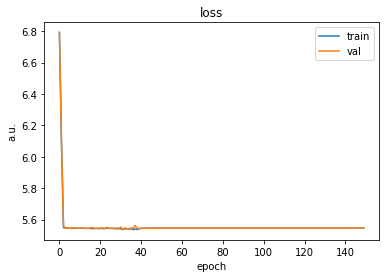

In [50]:
plt.plot(loss_train_list,label='train')
plt.plot(loss_val_list,label='val')
plt.legend(loc='upper right')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('a.u.')

Text(0, 0.5, 'value')

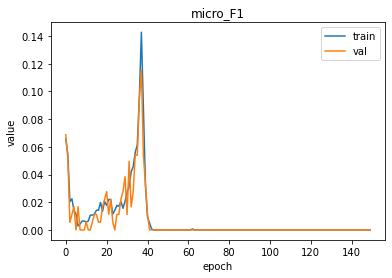

In [51]:
plt.plot(micro_F1_train_list,label='train')
plt.plot(micro_F1_val_list,label='val')
plt.legend(loc='upper right')
plt.title('micro_F1')
plt.xlabel('epoch')
plt.ylabel('value')

In [55]:
def test():
    low_layer.eval()
    output_ll, X_embedding_ = low_layer(Y_, X, E_tilde, A_tilde)
    loss_test = np.sum([F.binary_cross_entropy_with_logits(output_ll[idx_test][:,i], labels[idx_test][:,i]) for i in range(m)])
    micro_F1_train = micro_F1(threshold(output_ll.detach().numpy()[idx_test]), labels.detach().numpy()[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "micro_F1= {:.4f}".format(micro_F1_train.item()))
    return threshold(output_ll.detach().numpy()[idx_test])

In [56]:
y_predict = test()
y_predict = y_predict.astype(int)

Test set results: loss= 5.5452 micro_F1= 0.0000


In [52]:
from sklearn.metrics import classification_report

In [57]:
y_true = labels.numpy()[idx_test]
target_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
print(classification_report(y_true, y_predict, target_names=target_names))

              precision    recall  f1-score   support

           N       0.00      0.00      0.00        96
           D       0.00      0.00      0.00       116
           G       0.00      0.00      0.00        14
           C       0.00      0.00      0.00        28
           A       0.00      0.00      0.00        14
           H       0.00      0.00      0.00         8
           M       0.00      0.00      0.00        13
           O       0.00      0.00      0.00        69

   micro avg       0.00      0.00      0.00       358
   macro avg       0.00      0.00      0.00       358
weighted avg       0.00      0.00      0.00       358
 samples avg       0.00      0.00      0.00       358



/Users/linheshan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/linheshan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/linheshan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
